# Treinando uma rede para detecção de objetos com transfer learning
* Preparação de dados
* Comparação com modelo treinado com cocodaset e ground truth
* Comparação com modelo treinado com imagens especificas e ground truth

In [1]:
!ls /home/silvio/dataset/global-wheat-detection/

sample_submission.csv  t.csv  test  train  train.csv


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/home/silvio/dataset/global-wheat-detection'
#DIR_INPUT = '/home/silvio/dataset/gwd'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [3]:
train_df = pd.read_csv(f'{DIR_INPUT}/t.csv')
train_df.shape

(999, 5)

In [4]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [5]:
image_ids = train_df['image_id'].unique()

In [6]:
image_ids

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', '91c9d9c38', '41c0123cc',
       'c682d8c66', 'e46378032', '71fd03d51', '83a5d8ac8', '02b6f199c',
       '1bda74f14', '3e1e66c76', '4a3f67d2e', '2ccec6dcc', '0435654cd',
       '372d12c55', 'f5093f57d', 'c6b4933f7', '895420d9f', '8d6bb70e5',
       '531acb360', '4aeb37788', 'afb7671e5', 'cc9092474', 'c3c03e0b7',
       '42e247347', '5738fcf14', '31a6e55f2', 'ca4cb597b', '4e5c1078d',
       '29e44e305', '43e3ccd92', '4c7fc04f6'], dtype=object)

In [7]:
image_ids[-2:]

array(['43e3ccd92', '4c7fc04f6'], dtype=object)

In [8]:
image_ids[:-1]

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', '91c9d9c38', '41c0123cc',
       'c682d8c66', 'e46378032', '71fd03d51', '83a5d8ac8', '02b6f199c',
       '1bda74f14', '3e1e66c76', '4a3f67d2e', '2ccec6dcc', '0435654cd',
       '372d12c55', 'f5093f57d', 'c6b4933f7', '895420d9f', '8d6bb70e5',
       '531acb360', '4aeb37788', 'afb7671e5', 'cc9092474', 'c3c03e0b7',
       '42e247347', '5738fcf14', '31a6e55f2', 'ca4cb597b', '4e5c1078d',
       '29e44e305', '43e3ccd92'], dtype=object)

In [9]:
image_ids = train_df['image_id'].unique()
#valid_ids = image_ids[-665:]
#train_ids = image_ids[:-665]
valid_ids = image_ids[-12:]
train_ids = image_ids[:-12]

In [10]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [11]:
valid_df.shape, train_df.shape

((337, 8), (662, 8))

In [12]:
class WheatDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [13]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# dataset - dataloader - treino e avaliação
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [15]:
images, targets, image_ids = next(iter(valid_data_loader))

In [16]:
idimg=2

In [17]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [18]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
cpu_device = torch.device("cpu")

outputs2 = model(images)
outputs2 = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs2]

pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(outputs2[idimg]['labels'].numpy())] 
  
print(pred_class)      

z= outputs2[idimg]

sample2 = images[idimg].permute(1,2,0).cpu().numpy()
boxes2 = z['boxes'].detach().cpu().numpy().astype(np.int32)

[]


In [19]:
#sample4 = images[1].permute(1,2,0).cpu().numpy()
#boxes4 = z['boxes'].detach().cpu().numpy().astype(np.int32)

In [20]:
sample4 = images[idimg].permute(1,2,0).cpu().numpy()
boxes4 = targets[idimg]['boxes'].cpu().numpy().astype(np.int32)

# a esquerda - predição atual do modelo - a direita  groud trouth de mascara

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


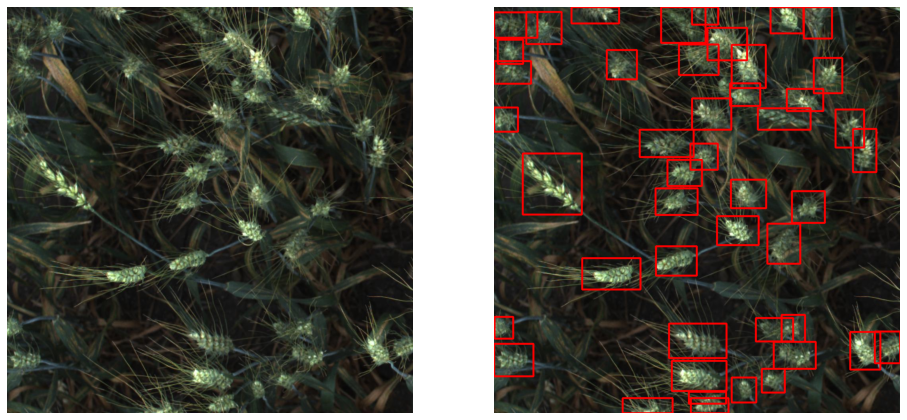

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

s1=sample2.copy()
s2=sample4.copy()
for box in boxes2:
    cv2.rectangle(s1,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

for box in boxes4:
    cv2.rectangle(s2,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)


ax[0].set_axis_off()
ax[0].imshow(s1)
ax[1].set_axis_off()
ax[1].imshow(s2)

In [22]:
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# transfer learning para identificar apenas um tipo de objeto

In [25]:
num_classes = 2  # 1 class (wheat) + background

# obtem numero de features do classificador
in_features = model2.roi_heads.box_predictor.cls_score.in_features

print(in_features)

# substitui a camada de entrada
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

1024


In [26]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [27]:
device = torch.device('cpu')

In [28]:
model2.to(device)
params = [p for p in model2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

# treino do modelo

In [29]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model2(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Epoch #0 loss: 3.5678997091300513
Epoch #1 loss: 1.7399651825711921


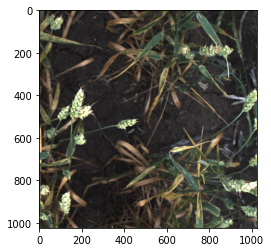

In [30]:
plt.imshow(images[idimg].permute(1,2,0).cpu().numpy())

In [31]:
model2.eval()
cpu_device = torch.device("cpu")

outputs22 = model2(images)
outputs22 = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs22]

pred_class22 = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(outputs22[idimg]['labels'].numpy())] 
  
print(pred_class22)   

['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']

In [32]:
#cpu_device = torch.device("cpu")

#outputs22 = model2(images)
#outputs22 = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs2]

z2= outputs22[idimg]

sample22 = images[idimg].permute(1,2,0).cpu().numpy()
boxes22 = z2['boxes'].detach().cpu().numpy().astype(np.int32)

In [ ]:
sample42 = images[idimg].permute(1,2,0).cpu().numpy()
boxes42 = targets[idimg]['boxes'].cpu().numpy().astype(np.int32)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

s1=sample22.copy()
s2=sample42.copy()
for box in boxes22:
    cv2.rectangle(s1,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

for box in boxes42:
    cv2.rectangle(s2,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)


ax[0].set_axis_off()
ax[0].imshow(s1)
ax[1].set_axis_off()
ax[1].imshow(s2)

In [ ]:
img = Image.open('/home/silvio/dataset/gwd/train/7b72ea0fb.jpg')

plt.imshow(img); 


In [ ]:

import torchvision.transforms as T

def get_prediction(img_path, threshold):
  # carrega a imagem usando componente PIL  
  img = Image.open(img_path) 
  # cria um objeto para representar um objeto como tensor  
  transform = T.Compose([T.ToTensor()]) 
  #aplica a função na imagem
  img = transform(img) 
  # realiza predição com modelo treinado, passando a imagem como entrada  
  pred = model([img]) 
  # O objeto pred criado contém uma lista com todos os lables identidicados
  # o objeto pred_class armazena a categoria encontrada
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] 
  
  print(pred_class)              

  # A função pred_boxes armazena os retangulos encontrados
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes

  # A função pred_score retorna os scores de cada objeto encontrado
  pred_score = list(pred[0]['scores'].detach().numpy())

  ## Obtem índice score maior que limiar passado
  #pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] 

  ## Seleciona apenas as predições acima do limiar passado
  #pred_boxes = pred_boxes[:pred_t+1]
  #pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1, text_th=1):

  boxes, pred_cls = get_prediction(img_path, threshold) 
  img = cv2.imread(img_path) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  # percorre retangulo encontrados
  for i in range(len(boxes)):
    # desenha o retangulo na imagem passada  
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(20,30)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
ls ../Aula3/6.jpg

In [ ]:
ls /home/silvio/dataset/gwd/test/

In [ ]:
#object_detection_api('6.jpg', threshold=0.1)
#object_detection_api('/home/silvio/dataset/gwd/train/7b72ea0fb.jpg', threshold=0.5)
#object_detection_api('/home/silvio/dataset/gwd/test/2fd875eaa.jpg', threshold=0.5)
object_detection_api('/home/silvio/dataset/gwd/test/f5a1f0358.jpg', threshold=0.5)
  
#object_detection_api('../Aula3/6.jpg', threshold=0.5)